# Imports

In [2]:
import sys
sys.path.append('../')
from datetime import datetime
import pandas as pd

# from src.run_all.main_preprocess import load_data, add_features
from src.utilities.utilities import get_latest_file

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Preprocess

In [3]:
%%time
# Load original sources and combine to one DataFrame
# df_dataset_WMO = load_data()

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.11 µs


In [4]:
%%time
# Feature engineering to get more features
# df_dataset_WMO_with_features = add_features(df_dataset_WMO)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.15 µs


## Optional: Write temporary result

In [5]:
# suffix_datetime = datetime.strftime(datetime.now(), format='%Y%m%d%H%M')

# df_dataset_WMO_with_features.to_parquet(f'../../data/df_preprocess_WMO_{suffix_datetime}.parquet.gzip',
#               compression='gzip')

# Train

## Optional: Load previous dataset

In [28]:
## Continue with loaded data from preprocess
# df = df_dataset_WMO_with_features.copy()

# ## HARDCODED
datapath = '../data/'
filename = 'df_preprocessed_202104042151_Boerenverstand_Maikel.parquet.gzip'
df = pd.read_parquet(datapath + filename)

# ## SELECT LAST FILE
# datapath = '../data/'
# df = get_latest_file(filename_str_contains='df_WMO_WIJK_HOUSEHOLDS_POP_LEVY_absolute_gemeente', datapath=datapath, filetype='parquet')

## Train model

### Train imports

In [29]:
# zorgen voor de juiste modules
import pandas as pd
import numpy as np
from datetime import datetime
import pickle

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, GridSearchCV, cross_validate, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, LassoCV, ElasticNet, BayesianRidge
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVR
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor, XGBClassifier, plot_importance

from src.utilities.transformers import ColumnSelector

# instellingen voor panda weergave aanpassen
pd.set_option('display.max_rows', 500) # alle rijen tonen
pd.set_option('display.max_columns', 500) # alle kolommen tonen
pd.set_option('display.width', 1000) # kolombreedte
pd.set_option("display.precision", 2)     # precisie van de kolommen aanpassen
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) # floats output tot 3 decimalen

### Settings

In [30]:
## Dataframe parameters
# locatie van dataset 
DF_LOCATION = 'C:/_NoBackup/Git/__JADS/WMO_execute_group_project/data/df_dataset_WMO.parquet.gzip'
# Location all data
datapath = '../../data/'
# manier van laden dataset. Bijvoorbeeld read_parquet of read_csv
DF_READ = pd.read_parquet

## X & Y parameters
# de kolommen die uit de X dataset moeten worden gehaald. Dat is in ieder geval de y en eventueel nog meer kolommen.
# X_DROP_VALUES = ['wmoclienten', 'eenpersoonshuishoudens', 'huishoudenszonderkinderen', 'huishoudensmetkinderen']
X_DROP_VALUES = ['wmoclienten', 'wmoclientenper1000inwoners', 'bedrijfsmotorvoertuigen',
                 'perioden', 'popcodea', 'popcodeb', 'popcodec', 'popcoded', 'popcodee', 'popcodef', 'popcodeg', 'popcodeh', 
                'popcodei', 'popcodej', 'popcodek', 'popcodel', 'popcodem', 'popcoden', 'popcodeo', 'popcodep', 'popcodeq', 
                'popcoder', 'popnaama', 'popnaamb', 'popnaamc', 'popnaamd', 'popnaame', 'popnaamf', 'popnaamg', 
                'popnaamh', 'popnaami', 'popnaamj', 'popnaamk', 'popnaaml', 'popnaamm', 'popnaamn', 'popnaamo',
                'popnaamp', 'popnaamq', 'popnaamr', 'popkoppelvariabeleregiocode', 'typemaatwerkarrangement', 
                'gemeentenaam', 'meestvoorkomendepostcode', 'dekkingspercentage', 
                 'gemgestandaardiseerdinkomenvanhuish', 'huishoudenstot110vansociaalminimum', 
                 'huishoudenstot120vansociaalminimum', 'mediaanvermogenvanparticulierehuish', 
                 'popafstandtotopenbaargroen', 'popafstandtotsportterrein', 'popagrarischterreinopp', 
                 'popagrarischterreinperc', 'popagrarischterreinperinwoner', 'popbebouwdterreinopp', 
                 'popbebouwdterreinperc', 'popbebouwdterreinperinwoner', 'popbosenopennatuurlijkterreinopp', 
                 'popbosenopennatuurlijkterreinperc', 'popbosenopennatuurlijkterreinperinwoner', 'popgemeenten', 
                 'poprecreatieterreinopp', 'poprecreatieterreinperc', 'poprecreatieterreinperinwoner', 
                 'popsemibebouwdterreinopp', 'popsemibebouwdterreinperc', 'popsemibebouwdterreinperinwoner', 
                 'popverkeersterreinopp', 'popverkeersterreinperc', 'popverkeersterreinperinwoner']
X_DROP_VALUES = ['wmoclienten', 'wmoclientenper1000inwoners']
# de kolom die wordt gebruikt als y value
Y_VALUE = ['wmoclientenper1000inwoners']
# test size voor de train/test split
TEST_SIZE = 0.3
# random state voor de train/test split. Bijvoorbeeld random_state = 42 als vaste seed voor reproduceerbaarheid
RANDOM_STATE = 42

## Pipeline parameters
# strategy en waarde om te vullen bij lege categorische kolommen
NAN_VALUES_CAT_STRATEGY = 'constant'
NAN_VALUES_CAT_VALUES = 'Missing'
# waarden om in te vullen bij lege numerieke kolommen. Bijvoorbeeld mean of median
NAN_VALUES_NUM_STRATEGY = 'mean'
# 
#COLS_SELECT = ['aantalinwoners', 'mannen', 'vrouwen', 'k0tot15jaar'
#               , 'k15tot25jaar', 'k25tot45jaar', 'k45tot65jaar', 'k65jaarofouder', 'gescheiden'
#               , 'verweduwd', 'westerstotaal', 'sterftetotaal', 'gemiddeldehuishoudensgrootte'
#               , 'gemiddeldewoningwaarde', 'koopwoningen', 'huurwoningentotaal', 'inbezitwoningcorporatie'
#               , 'gemiddeldinkomenperinkomensontvanger', 'k40personenmetlaagsteinkomen', 'k20personenmethoogsteinkomen'
#               , 'actieven1575jaar', 'k40huishoudensmetlaagsteinkomen', 'k20huishoudensmethoogsteinkomen'
#               , 'huishoudensmeteenlaaginkomen', 'personenpersoortuitkeringaow', 'rucultuurrecreatieoverigediensten'
#               , 'personenautosperhuishouden', 'matevanstedelijkheid']
COLS_SELECT = None

## Model parameters
# manier van cross validate in de modellen. Bijvoorbeeld 10 of RepeatedKFold(n_splits=30, n_repeats=5, random_state=1)
CROSS_VALIDATE = 10
# manier van scoren in de modellen
MODEL_SCORING = 'neg_mean_squared_error'

## Scoring parameters
# Deze kunnen we later toevoegen als we meerdere manieren van scoren hebben. Dus niet alleen maar de RSMLE

### Functions

In [31]:
# functie maken om op basis van de cv scores, het beste RMLSE model te selecteren 
def get_best_model_rmsle(cv_scores):
    """
    Return best (most conservative) model from cross_validate object.
    
    Uses np.argmax to find bottomright point == largest RMSE
    """
    index = np.argmax(np.sqrt(-cv_scores['train_neg_mean_squared_error']))
    model = cv_scores['estimator'][index]
    rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
    return (rmse)

### Load data

In [32]:
# ## Done before start of 'Train' chapter
# df = get_latest_file(mypath=datapath)

#### Stappen hieronder mogelijk verplaatsten naar prepare stap, later beoordelen

In [33]:
# droppen van de rijen waar de y_value leeg is, anders kunnen de modellen er niet mee overweg
df.dropna(
    axis=0,
    how='any',
    thresh=None,
    subset=Y_VALUE,
    inplace=True
)

In [34]:
df.columns

Index(['wmoclienten', 'wmoclientenper1000inwoners', 'aantalinwoners', 'gemiddeldehuishoudensgrootte', 'gescheiden', 'verweduwd', 'alleenstaande_mannen', 'alleenstaande_vrouwen', 'ouder_in_eenouderhuishouden_mannen', 'ouder_in_eenouderhuishouden_vrouwen', 'popaantalrestaurantsbinnen3km', 'popafstandtothuisartsenpraktijk', 'poparbeidsongeschiktheidtotaal', 'popbevolkingsdichtheid', 'popeenpersoonshuishoudensrelatief', 'popk65tot80jaarrelatieveleeftijdsgroep', 'popk80jaarofouderrelatieveleeftijdsgroep', 'popomgevingsadressendichtheid', 'poppersonenautosrelatief', 'popwerkloosheid', 'relative_mannen', 'relative_vrouwen', 'relative_alleenstaande_mannen', 'relative_alleenstaande_vrouwen', 'relative_gescheiden', 'relative_ongehuwd', 'relative_ouder_in_eenouderhuishouden_vrouwen', 'relative_ouder_in_eenouderhuishouden_mannen', 'relative_eenpersoonshuishoudens', 'relative_huishoudenszonderkinderen', 'relative_huishoudensmetkinderen', 'relative_popaantalrestaurantsbinnen3km',
       'relative_po

In [35]:
# X en y aanmaken
X = df.drop(X_DROP_VALUES, axis=1)
# y = df[Y_VALUE]*100 # 0.01 -> 1.0 percentage
y = df[Y_VALUE] # 0.01 -> 1.0 percentage

In [36]:
# splitsen van X en y in train/test. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, random_state = RANDOM_STATE)

In [37]:
# splitsen van X_train in categorische en numerieke kolommen, om apart te kunnen transformeren
cat_cols = X_train.select_dtypes(include=['category']).columns
num_cols = X_train.select_dtypes(include=['int64','float64','float32','int32']).columns

### Pipelines

In [38]:
# pipelines (pl) maken voor imputing, scaling en OneHotEncoding per datatype 

# categorie met waarde die is gegeven aan "MISSING" toevoegen
for col in cat_cols:
    # need to add category for missings, otherwise error with OneHotEncoding (volgens mij ook met alleen imputing)
    X_train[col].cat.add_categories(NAN_VALUES_CAT_VALUES, inplace=True)
categories = [X_train[col].cat.categories for col in cat_cols]

# pipeline voor categorial datatype
pl_ppc_cat = make_pipeline(
     SimpleImputer(
         missing_values = np.nan
        ,strategy = NAN_VALUES_CAT_STRATEGY
        ,fill_value = NAN_VALUES_CAT_VALUES)
    ,OneHotEncoder(categories=categories)
)

# pipeline voor numeriek datatype
pl_ppc_num = make_pipeline(
      ColumnSelector(cols=COLS_SELECT)
    ,SimpleImputer(
         missing_values = np.nan
        ,strategy = NAN_VALUES_NUM_STRATEGY)
    ,StandardScaler()
)

In [39]:
# pipelines maken om de preprocessing van de imputing te combineren
pl_ppc_total = make_column_transformer(
     (pl_ppc_cat, cat_cols)
    ,(pl_ppc_num, num_cols)
    ,remainder = 'drop'
)

### Feature importance & feature selection

In [40]:
# de X train door bovenstaande pipelines heen halen en opslaan in X_train_prepared
X_train_prepared = pl_ppc_total.fit_transform(X_train)
# de X_train_prepared weer omzetten naar dataframe, inclusief column names
X_train = pd.DataFrame(data=X_train_prepared, columns=[num_cols])

In [41]:
# kiezen van het model waarmee feature importance wordt bepaald, bijvoorbeeld:
    # RandomForestRegressor(random_state=42)
    # XGBRegressor(n_estimators=100, random_state = 42)
FI_MODEL = XGBRegressor(n_estimators=100, random_state = 42)
FI_MODEL.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [42]:
fi = FI_MODEL.feature_importances_
fi_list = sorted(zip(fi, num_cols), reverse=True)
# met de [:n] kun je het aantal features aanpassen dat getoond moet worden
fi_df_top_n = pd.DataFrame(fi_list[:30])
fi_df_top_n

,0,1
0,0.213,relative_huishoudensmetkinderen
1,0.118,relative_poparbeidsongeschiktheidtotaal
2,0.069,popk80jaarofouderrelatieveleeftijdsgroep
3,0.042,ouder_in_eenouderhuishouden_vrouwen
4,0.035,relative_poptotaleoppervlakte
5,0.033,relative_popbevolkingsdichtheid
6,0.027,relative_huishoudenszonderkinderen
7,0.027,popafstandtothuisartsenpraktijk
8,0.026,relative_popmatigstedelijk
9,0.026,popk65tot80jaarrelatieveleeftijdsgroep


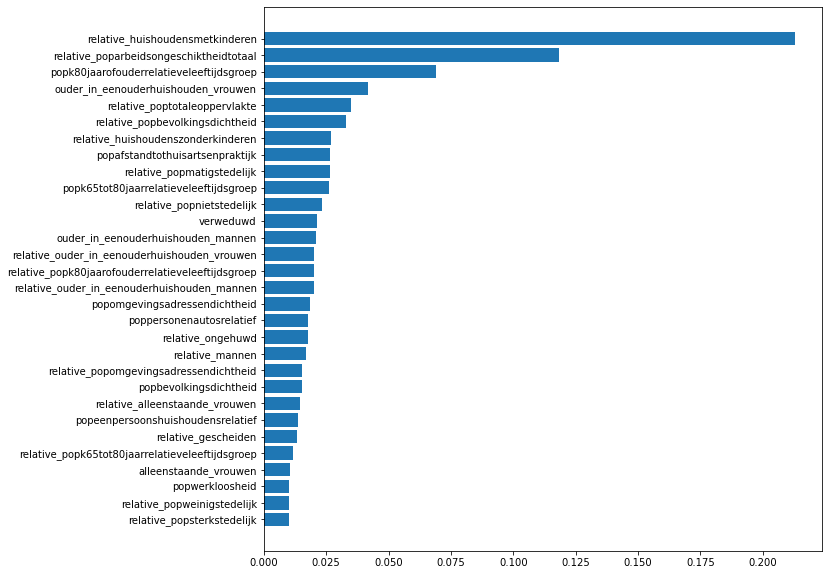

In [43]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 10))
plt.barh(fi_df_top_n[1], fi_df_top_n[0],)
plt.gca().invert_yaxis()

In [44]:
# lasso (cross validate) uitvoeren
feature_selection = LassoCV(cv=10).fit(X_train, y_train)
# lijst aanmaken met coefficienten per feature
feature_selection_coef_list = sorted(zip(np.abs(feature_selection.coef_), num_cols), reverse=True)
df_coef = pd.DataFrame(feature_selection_coef_list, columns=['coef','feature']) 

/usr/local/Caskroom/miniconda/base/envs/jads-env/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/usr/local/Caskroom/miniconda/base/envs/jads-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.852024543364678, tolerance: 3.7819231182723088
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/Caskroom/miniconda/base/envs/jads-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.307081141792878, tolerance: 3.7819231182723088
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/Caskroom/miniconda/ba

/usr/local/Caskroom/miniconda/base/envs/jads-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.870330536803522, tolerance: 3.8363217637049507
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/Caskroom/miniconda/base/envs/jads-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.946240517539991, tolerance: 3.8363217637049507
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/Caskroom/miniconda/base/envs/jads-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.838421902488335, tolerance: 3.8363217637049507
  model = cd_fast.enet_coordinate_des

/usr/local/Caskroom/miniconda/base/envs/jads-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.025869003351545, tolerance: 3.8346566329600664
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/Caskroom/miniconda/base/envs/jads-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.738741787215986, tolerance: 3.8346566329600664
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/Caskroom/miniconda/base/envs/jads-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.280804079389782, tolerance: 3.8346566329600664
  model = cd_fast.enet_coordinate_des

In [45]:
# laat de N features zien met de hoogste coefficienten
df_coef.head(30)

,coef,feature
0,2.644,relative_poparbeidsongeschiktheidtotaal
1,1.851,relative_ongehuwd
2,1.236,popeenpersoonshuishoudensrelatief
3,1.122,popk80jaarofouderrelatieveleeftijdsgroep
4,0.769,relative_huishoudensmetkinderen
5,0.746,popbevolkingsdichtheid
6,0.575,relative_popafstandtothuisartsenpraktijk
7,0.533,relative_mannen
8,0.512,verweduwd
9,0.346,popafstandtothuisartsenpraktijk


In [26]:
coef_0_cols_df = df_coef[df_coef["coef"] == 0]
coef_0_cols_list = coef_0_cols_df['feature'].values.tolist()
coef_0_cols_list

['woningvoorraad',
 'westerstotaal',
 'vrouwen',
 'verweduwd',
 'turkije',
 'totaal_personen_vrouwen',
 'totaal_personen_totaal_mannen_en_vrouwen',
 'totaal_personen_mannen',
 'totaal_onroerendezaakbelasting_gemeenteheffing1000euro',
 'toeristenbelasting_gemeenteheffing1000euro',
 'thuiswonend_kind_vrouwen',
 'thuiswonend_kind_totaal_mannen_en_vrouwen',
 'thuiswonend_kind_mannen',
 'suriname',
 'sterftetotaal',
 'secretarieleges_burgerzaken_gemeenteheffing1000euro',
 'scholenbinnen3km',
 'rucultuurrecreatieoverigediensten',
 'rioolheffing_gemeenteheffingeuroinwoner',
 'rioolheffing_gemeenteheffing1000euro',
 'reinigingsrechten_en_afvalstoffenheffing_gemeenteheffingeuroinwoner',
 'reinigingsrechten_en_afvalstoffenheffing_gemeenteheffing1000euro',
 'precariobelasting_gemeenteheffingeuroinwoner',
 'precariobelasting_gemeenteheffing1000euro',
 'popziektenvanhartenvaatstelsel',
 'popziektenvanademhalingsstelsel',
 'popzeersterkstedelijk',
 'popwoningen',
 'popwoningdichtheid',
 'popwiauitke

## To do (logistic regression/continious waarden)

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [ ]:
feature_importance_model_logistic_regression = LogisticRegression()
rfe = RFE(feature_importance_model_logistic_regression, 15)
fit = rfe.fit(X_train_prepared, y_train)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

In [ ]:
from sklearn.feature_selection import SelectFromModel
sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1'))
sel_.fit(X_train_prepared, y_train)

## Gridsearch

In [ ]:
%%time
GRIDSEARCH_MODEL = RandomForestRegressor(random_state=42)
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(GRIDSEARCH_MODEL, param_grid, cv=2,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_train_prepared, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_estimator_

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
important_attributes = sorted(zip(feature_importances, num_cols), reverse=True)
important_attributes[:15]